# Import Libraries

In [1]:
# =============================================================================
# 📦 STANDARD LIBRARIES
# =============================================================================
import warnings
import numpy as np
import pandas as pd

# =============================================================================
# 📊 VISUALIZATION
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# 🤖 MACHINE LEARNING & PREPROCESSING
# =============================================================================
from sklearn.model_selection import KFold, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from category_encoders import TargetEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

# =============================================================================
# 🔧 SETTINGS / WARNINGS / ENVIRONMENT
# =============================================================================
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid")

# Load Data

In [2]:
# 📥 Load the dataset
train = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")

original = pd.read_csv("/kaggle/input/loan-prediction-dataset-2025/loan_dataset_20000.csv")


# Add a 'dataset' column to track source
train['dataset'] = 'train'
test['dataset'] = 'test'

original['dataset'] = 'train'



# Combine train and test datasets for unified preprocessing
df = pd.concat([train, test, original], axis=0).reset_index(drop=True)

# 🧾 Display dataset shape
print("Dataset shape:", df.shape)

# 👁️ Preview the data
df

Dataset shape: (868563, 24)


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,dataset,age,monthly_income,loan_term,installment,num_of_open_accounts,total_credit_limit,current_balance,delinquency_history,public_records,num_of_delinquencies
0,0.0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0,train,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868558,NaN,39640.08,0.275,691,16322.23,15.05,Female,Married,Bachelor's,Employed,Debt consolidation,C5,0.0,train,39.0,3303.34,36.0,566.22,2.0,23748.10,5801.45,1.0,0.0,4.0
868559,NaN,32062.90,0.367,758,16697.34,11.89,Female,Married,Bachelor's,Employed,Debt consolidation,B5,1.0,train,66.0,2671.91,36.0,553.71,8.0,49929.65,40901.31,3.0,0.0,3.0
868560,NaN,18642.02,0.106,751,23924.78,10.06,Female,Single,Master's,Student,Debt consolidation,B4,1.0,train,65.0,1553.50,36.0,772.66,3.0,13137.57,5075.67,1.0,0.0,2.0
868561,NaN,22181.39,0.275,646,16920.13,16.06,Male,Married,Master's,Retired,Other,D2,1.0,train,35.0,1848.45,36.0,595.36,5.0,19580.82,3876.16,4.0,0.0,5.0


In [3]:
train

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back,dataset
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0,train
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0,train
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0,train
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0,train
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593989,593989,23004.26,0.152,703,20958.37,10.92,Female,Single,High School,Employed,Business,C3,1.0,train
593990,593990,35289.43,0.105,559,3257.24,14.62,Male,Single,Bachelor's,Employed,Debt consolidation,F5,1.0,train
593991,593991,47112.64,0.072,675,929.27,14.13,Female,Married,Bachelor's,Employed,Debt consolidation,C1,1.0,train
593992,593992,76748.44,0.067,740,16290.40,9.87,Male,Single,Bachelor's,Employed,Debt consolidation,B2,1.0,train


In [4]:
test

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,dataset
0,593994,28781.05,0.049,626,11461.42,14.73,Female,Single,High School,Employed,Other,D5,test
1,593995,46626.39,0.093,732,15492.25,12.85,Female,Married,Master's,Employed,Other,C1,test
2,593996,54954.89,0.367,611,3796.41,13.29,Male,Single,Bachelor's,Employed,Debt consolidation,D1,test
3,593997,25644.63,0.110,671,6574.30,9.57,Female,Single,Bachelor's,Employed,Debt consolidation,C3,test
4,593998,25169.64,0.081,688,17696.89,12.80,Female,Married,PhD,Employed,Business,C1,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...
254564,848558,92835.97,0.068,744,29704.00,13.48,Female,Single,Bachelor's,Employed,Debt consolidation,B2,test
254565,848559,48846.47,0.091,634,20284.33,9.58,Female,Married,High School,Employed,Debt consolidation,D4,test
254566,848560,20668.52,0.096,718,26387.55,9.00,Male,Single,Master's,Employed,Debt consolidation,C4,test
254567,848561,34105.09,0.094,739,11107.36,9.81,Male,Single,Bachelor's,Employed,Business,C2,test


# Initial Data Inspection

In [5]:
df.shape

(868563, 24)

In [6]:
# 📋 Check column types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 868563 entries, 0 to 868562
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    848563 non-null  float64
 1   annual_income         868563 non-null  float64
 2   debt_to_income_ratio  868563 non-null  float64
 3   credit_score          868563 non-null  int64  
 4   loan_amount           868563 non-null  float64
 5   interest_rate         868563 non-null  float64
 6   gender                868563 non-null  object 
 7   marital_status        868563 non-null  object 
 8   education_level       868563 non-null  object 
 9   employment_status     868563 non-null  object 
 10  loan_purpose          868563 non-null  object 
 11  grade_subgrade        868563 non-null  object 
 12  loan_paid_back        613994 non-null  float64
 13  dataset               868563 non-null  object 
 14  age                   20000 non-null   float64
 15  

In [7]:
# ✅ Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'bool']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['id', 'annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate', 'loan_paid_back', 'age', 'monthly_income', 'loan_term', 'installment', 'num_of_open_accounts', 'total_credit_limit', 'current_balance', 'delinquency_history', 'public_records', 'num_of_delinquencies']
Categorical Columns: ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'dataset']


In [8]:
# 🔍 Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0]
missing_df

,Missing Values,Percentage
id,20000,2.302654
loan_paid_back,254569,29.309215
age,848563,97.697346
monthly_income,848563,97.697346
loan_term,848563,97.697346
installment,848563,97.697346
num_of_open_accounts,848563,97.697346
total_credit_limit,848563,97.697346
current_balance,848563,97.697346
delinquency_history,848563,97.697346


In [9]:
# 📊 Descriptive statistics for numerical columns
df[numerical_cols].describe()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,loan_paid_back,age,monthly_income,loan_term,installment,num_of_open_accounts,total_credit_limit,current_balance,delinquency_history,public_records,num_of_delinquencies
count,848563.000000,868563.000000,868563.000000,868563.000000,868563.000000,868563.000000,613994.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,424281.000000,48110.959184,0.121960,680.913471,15021.768836,12.356186,0.798855,48.027000,3629.136466,43.22280,455.625793,5.011800,48649.824769,24333.394631,1.990150,0.061800,2.489150
std,244959.182573,26769.993245,0.070142,55.851578,6968.478051,2.022528,0.400857,15.829352,2389.048326,11.00838,274.622125,2.244529,32423.378128,22313.845395,1.474945,0.285105,1.631384
min,0.000000,6000.000000,0.010000,373.000000,500.000000,3.140000,0.000000,21.000000,500.000000,36.00000,9.430000,0.000000,6157.800000,496.350000,0.000000,0.000000,0.000000
25%,212140.500000,27795.925000,0.072000,646.000000,10235.900000,10.990000,1.000000,35.000000,2021.730000,36.00000,253.910000,3.000000,27180.492500,9592.572500,1.000000,0.000000,1.000000
50%,424281.000000,46330.040000,0.096000,682.000000,15000.220000,12.370000,1.000000,48.000000,3048.770000,36.00000,435.595000,5.000000,40241.615000,18334.555000,2.000000,0.000000,2.000000
75%,636421.500000,60953.550000,0.158000,719.000000,18924.245000,13.690000,1.000000,62.000000,4556.495000,60.00000,633.595000,6.000000,60361.257500,31743.327500,3.000000,0.000000,3.000000
max,848562.000000,400000.000000,0.667000,850.000000,49039.690000,22.510000,1.000000,75.000000,33333.330000,60.00000,1685.400000,15.000000,454394.190000,352177.900000,11.000000,2.000000,11.000000


In [10]:
# 🔢 Unique value counts for categorical columns
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].value_counts())


Unique values in 'gender':
gender
Female    447689
Male      415074
Other       5800
Name: count, dtype: int64

Unique values in 'marital_status':
marital_status
Single      421560
Married     405213
Divorced     31862
Widowed       9928
Name: count, dtype: int64

Unique values in 'education_level':
education_level
Bachelor's     407575
High School    268198
Master's       136647
Other           39510
PhD             16633
Name: count, dtype: int64

Unique values in 'employment_status':
employment_status
Employed         656859
Unemployed        91313
Self-employed     77946
Retired           24689
Student           17756
Name: count, dtype: int64

Unique values in 'loan_purpose':
loan_purpose
Debt consolidation    471639
Other                  94139
Car                    85387
Home                   65074
Education              54035
Business               52008
Medical                33620
Vacation               12661
Name: count, dtype: int64

Unique values in 'grade_subgrade':
gr

# Exploratory Data Analysis (EDA)

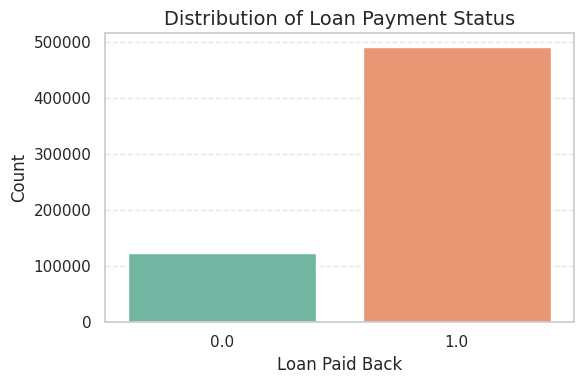

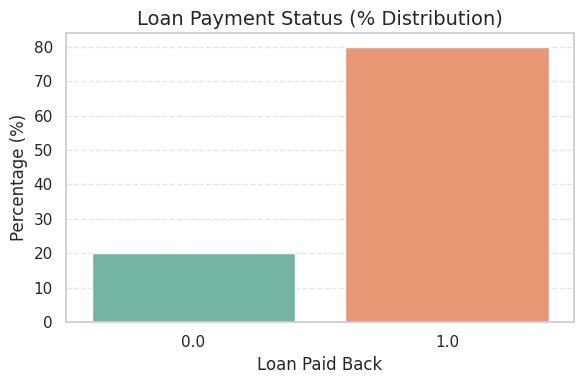


📊 Loan Payment Status Summary:
loan_paid_back
1.0    490492
0.0    123502
Name: count, dtype: int64

🔢 Percentage Distribution:
loan_paid_back
1.0    79.89%
0.0    20.11%
Name: proportion, dtype: object


In [11]:
# 🎯 Target Variable Distribution (Categorical)
# Target: "loan_paid_back"

import matplotlib.pyplot as plt
import seaborn as sns

# ---
## 1. Count Plot: Showing the Frequency Distribution
# ---

plt.figure(figsize=(6, 4))
# Use 'countplot' for categorical data
sns.countplot(data=df, x='loan_paid_back', palette='Set2')

plt.title('Distribution of Loan Payment Status', fontsize=14)
plt.xlabel('Loan Paid Back', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---
## 2. Percentage Distribution
# ---

# Calculate the percentage of each category
category_counts = df['loan_paid_back'].value_counts(normalize=True) * 100

# Create a bar plot for percentage distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='Set2')

plt.title('Loan Payment Status (% Distribution)', fontsize=14)
plt.xlabel('Loan Paid Back', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---
## 3. Descriptive Statistics (Categorical Summary)
# ---

print("\n📊 Loan Payment Status Summary:")
print(df['loan_paid_back'].value_counts())
print("\n🔢 Percentage Distribution:")
print((df['loan_paid_back'].value_counts(normalize=True) * 100).round(2).astype(str) + '%')

--- Visualizing: annual_income ---


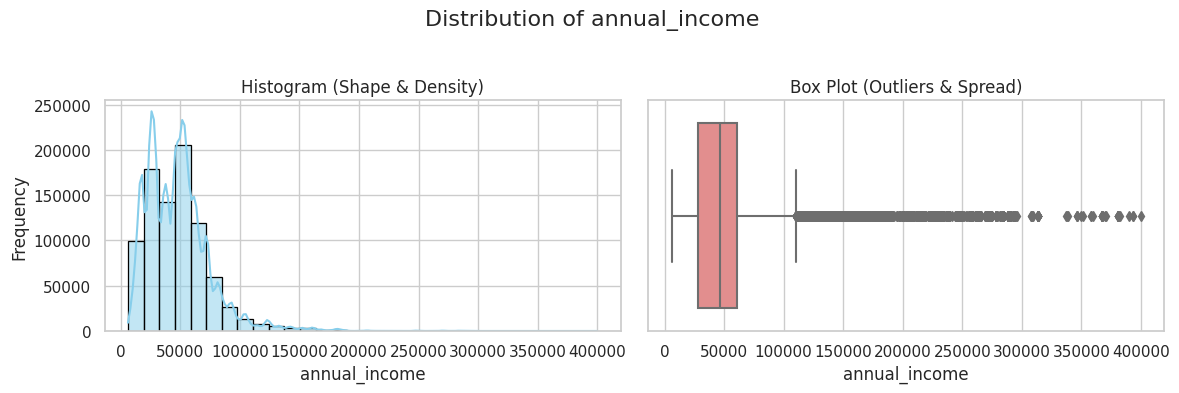


📊 Descriptive Statistics:
count    868563.000
mean      48110.959
std       26769.993
min        6000.000
25%       27795.925
50%       46330.040
75%       60953.550
max      400000.000
Name: annual_income, dtype: float64


--- Visualizing: debt_to_income_ratio ---


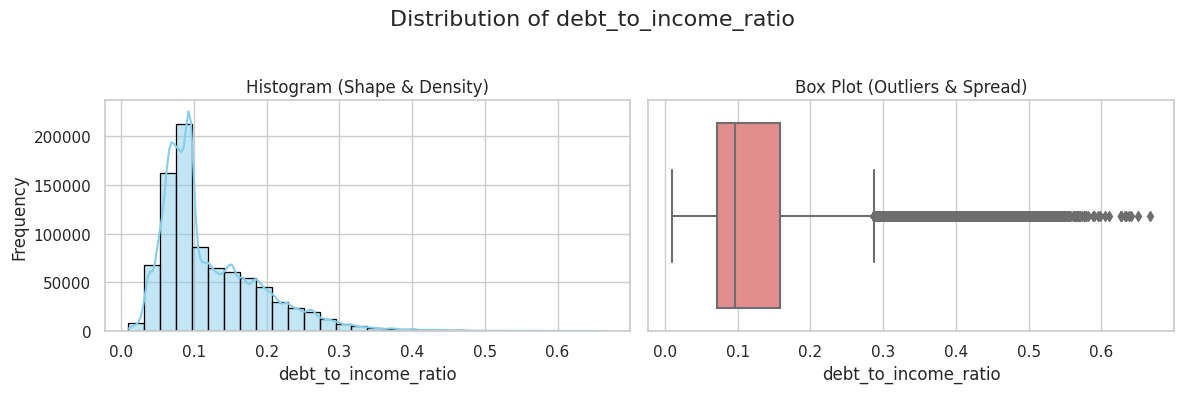


📊 Descriptive Statistics:
count    868563.000
mean          0.122
std           0.070
min           0.010
25%           0.072
50%           0.096
75%           0.158
max           0.667
Name: debt_to_income_ratio, dtype: float64


--- Visualizing: credit_score ---


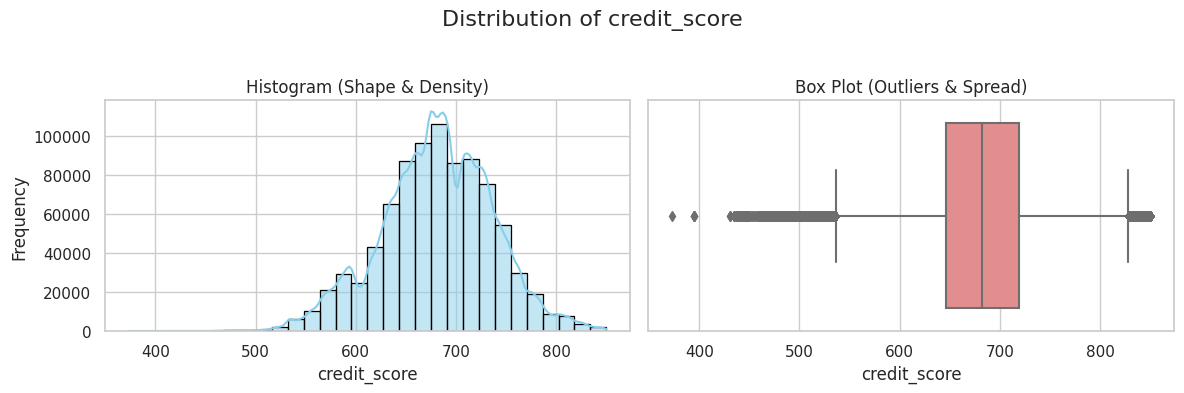


📊 Descriptive Statistics:
count    868563.000
mean        680.913
std          55.852
min         373.000
25%         646.000
50%         682.000
75%         719.000
max         850.000
Name: credit_score, dtype: float64


--- Visualizing: loan_amount ---


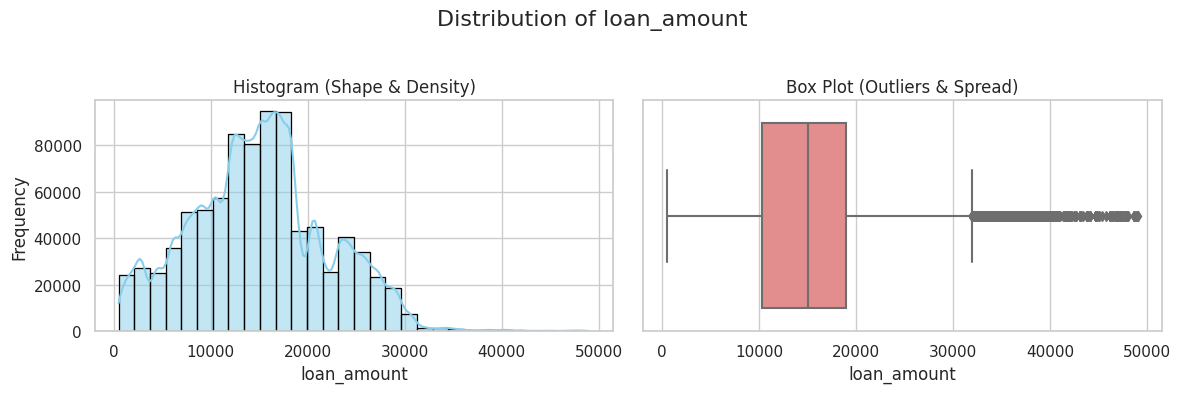


📊 Descriptive Statistics:
count    868563.000
mean      15021.769
std        6968.478
min         500.000
25%       10235.900
50%       15000.220
75%       18924.245
max       49039.690
Name: loan_amount, dtype: float64


--- Visualizing: interest_rate ---


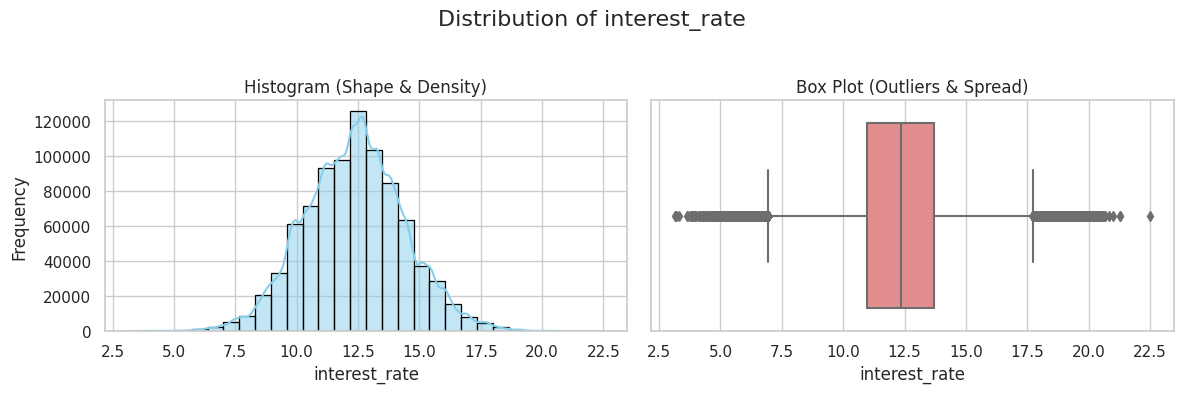


📊 Descriptive Statistics:
count    868563.000
mean         12.356
std           2.023
min           3.140
25%          10.990
50%          12.370
75%          13.690
max          22.510
Name: interest_rate, dtype: float64




In [12]:
# -------------------------------------------------------
# 🎯 Feature Distribution Visualization (Numerical Features)
# Target: loan_paid_back (Categorical)
# -------------------------------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical columns based on your dataset
numerical_cols = [
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

# Separate the columns based on their nature
continuous_features = [
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

# (If you later add any discrete numeric features, like num_of_loans, put them here)
discrete_features = []

# Loop through each numerical column
for col in numerical_cols:
    print(f"--- Visualizing: {col} ---")

    # Set up a figure with two subplots side-by-side
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f'Distribution of {col}', fontsize=16)

    if col in continuous_features:
        # Left: Histogram for density/shape
        sns.histplot(df[col].dropna(), kde=True, bins=30,
                     ax=axes[0], color='skyblue', edgecolor='black')
        axes[0].set_title('Histogram (Shape & Density)')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Frequency')

        # Right: Boxplot for quartiles/outliers
        sns.boxplot(x=df[col].dropna(), ax=axes[1], color='lightcoral')
        axes[1].set_title('Box Plot (Outliers & Spread)')
        axes[1].set_xlabel(col)

    elif col in discrete_features:
        # Left: Count Plot for small integer-like features
        sns.countplot(x=df[col].dropna(), ax=axes[0], palette='viridis', edgecolor='black')
        axes[0].set_title('Count Plot (Frequency)')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Count')

        # Right: Boxplot (still useful)
        sns.boxplot(x=df[col].dropna(), ax=axes[1], color='lightcoral')
        axes[1].set_title('Box Plot (Summary)')
        axes[1].set_xlabel(col)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print descriptive statistics
    print("\n📊 Descriptive Statistics:")
    print(df[col].describe().round(3))
    print("\n" + "="*50 + "\n")

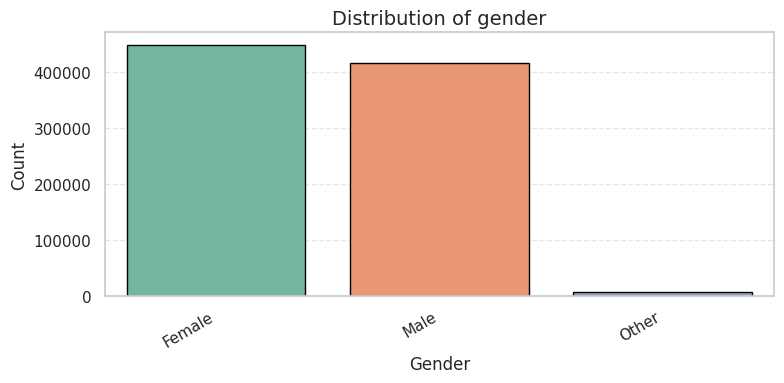


📊 Proportion of Each Category in "gender":

gender
Female    0.515
Male      0.478
Other     0.007
Name: proportion, dtype: float64 
----------------------------------------


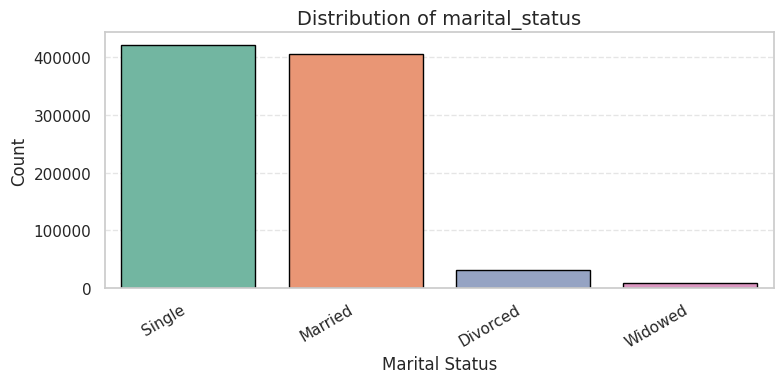


📊 Proportion of Each Category in "marital_status":

marital_status
Single      0.485
Married     0.467
Divorced    0.037
Widowed     0.011
Name: proportion, dtype: float64 
----------------------------------------


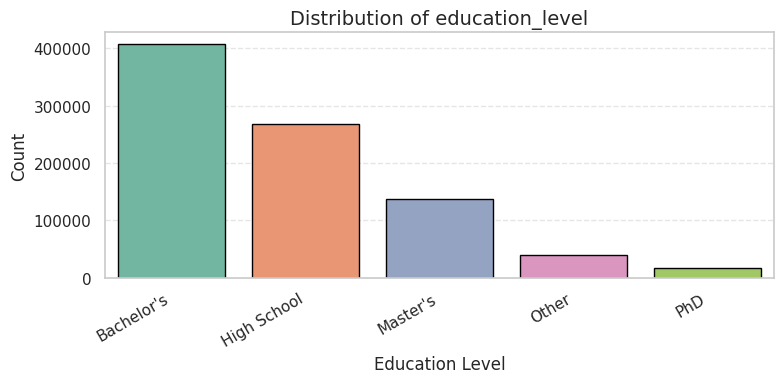


📊 Proportion of Each Category in "education_level":

education_level
Bachelor's     0.469
High School    0.309
Master's       0.157
Other          0.045
PhD            0.019
Name: proportion, dtype: float64 
----------------------------------------


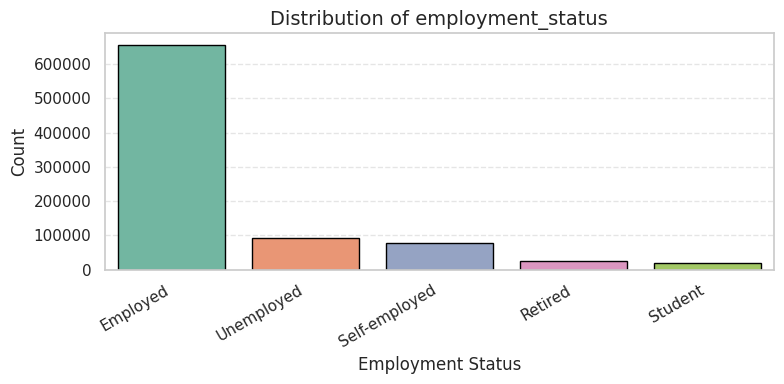


📊 Proportion of Each Category in "employment_status":

employment_status
Employed         0.756
Unemployed       0.105
Self-employed    0.090
Retired          0.028
Student          0.020
Name: proportion, dtype: float64 
----------------------------------------


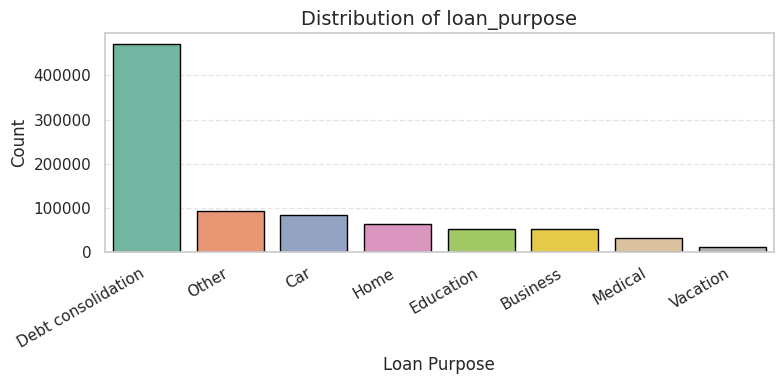


📊 Proportion of Each Category in "loan_purpose":

loan_purpose
Debt consolidation    0.543
Other                 0.108
Car                   0.098
Home                  0.075
Education             0.062
Business              0.060
Medical               0.039
Vacation              0.015
Name: proportion, dtype: float64 
----------------------------------------


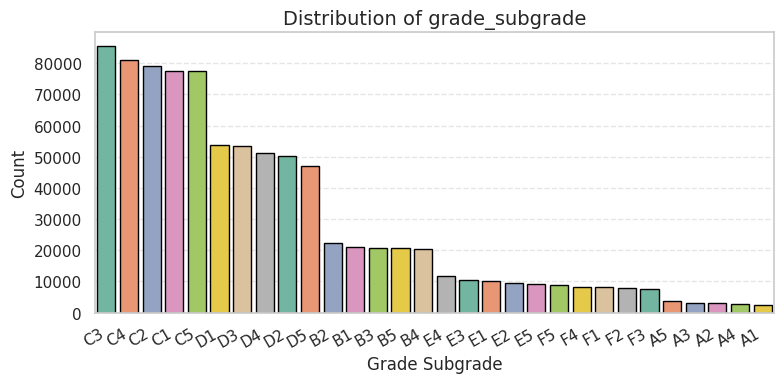


📊 Proportion of Each Category in "grade_subgrade":

grade_subgrade
C3    0.099
C4    0.093
C2    0.091
C1    0.089
C5    0.089
D1    0.062
D3    0.062
D4    0.059
D2    0.058
D5    0.054
B2    0.026
B1    0.024
B3    0.024
B5    0.024
B4    0.024
E4    0.014
E3    0.012
E1    0.012
E2    0.011
E5    0.010
F5    0.010
F4    0.010
F1    0.009
F2    0.009
F3    0.009
A5    0.004
A3    0.004
A2    0.004
A4    0.003
A1    0.003
Name: proportion, dtype: float64 
----------------------------------------


In [13]:
# 📊 Distribution of Categorical Features

# Updated list with the categorical columns from your dataset
cat_cols = [
    'gender',
    'marital_status',
    'education_level',
    'employment_status',
    'loan_purpose',
    'grade_subgrade'
]

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        data=df,
        x=col,
        order=df[col].value_counts().index,  # order bars by frequency
        palette='Set2',
        edgecolor='black'
    )

    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Count', fontsize=12)

    # Rotate labels if categories are long
    plt.xticks(rotation=30, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # 🧮 Print Category Proportions
    print(f'\n📊 Proportion of Each Category in "{col}":\n')
    print(df[col].value_counts(normalize=True).round(3), '\n' + '-'*40)

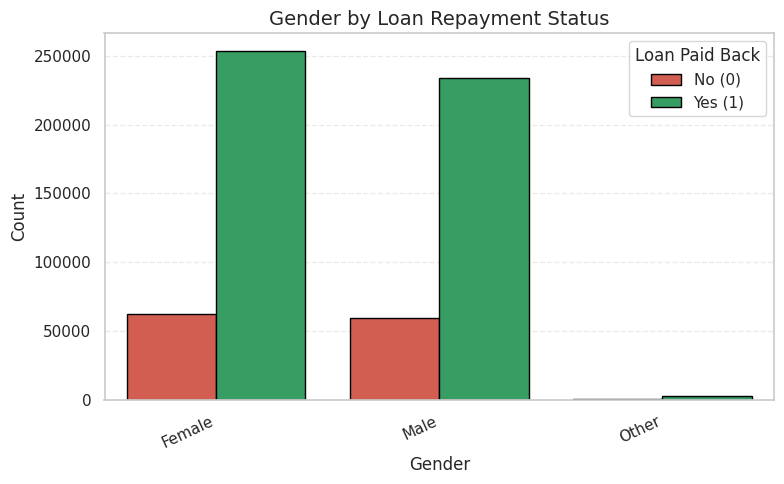

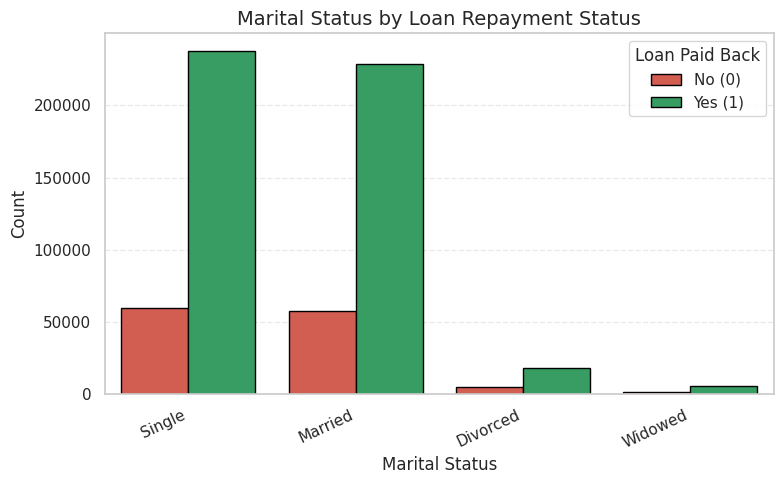

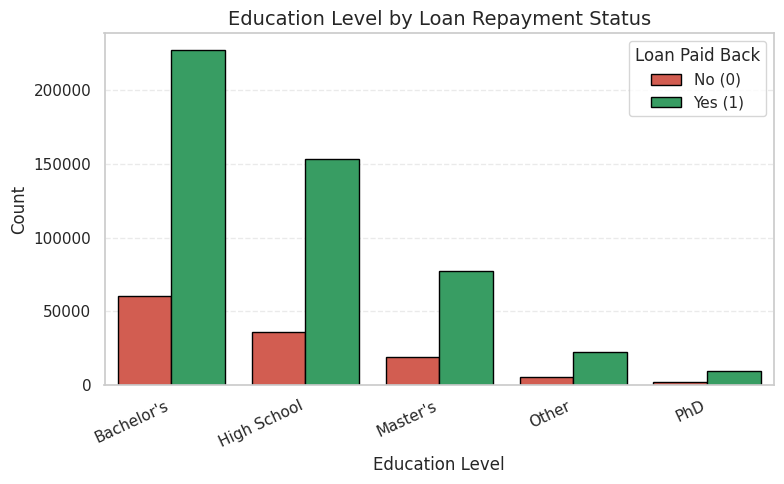

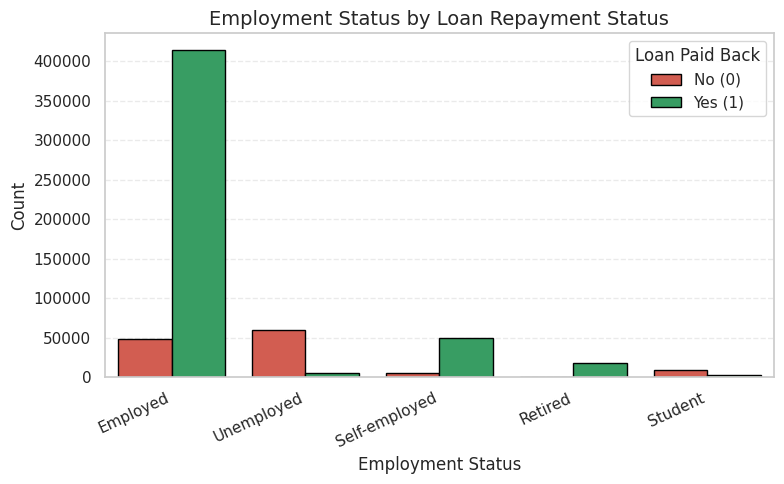

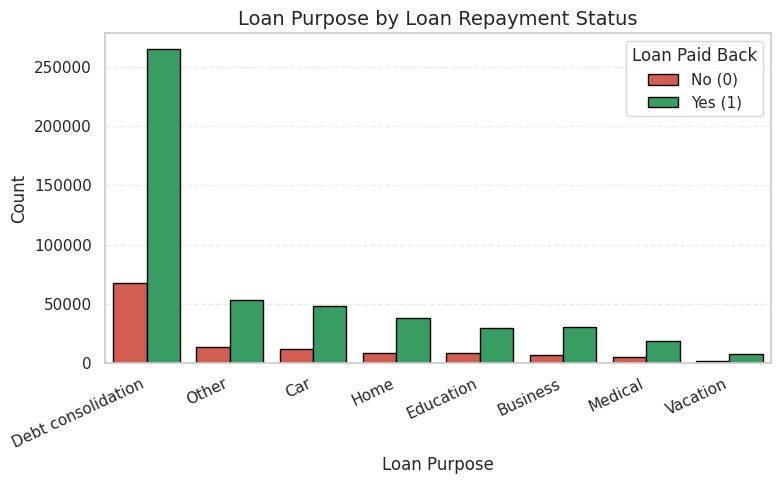

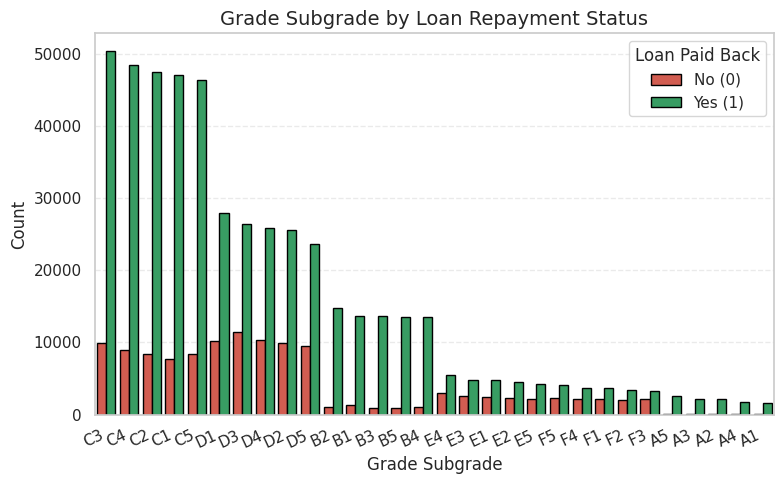

In [14]:
# 🎨 Categorical Feature Distributions by Loan Repayment Status - Custom Colors

# Select key categorical columns to explore their relationship with the target
cols_to_plot = [
    'gender',
    'marital_status',
    'education_level',
    'employment_status',
    'loan_purpose',
    'grade_subgrade'
]

# Custom colors: green for Paid (1), red for Not Paid (0)
custom_palette = ['#E74C3C', '#27AE60']  # Red = Not Paid, Green = Paid

target_col = 'loan_paid_back'  # Binary target variable (0 or 1)

for col in cols_to_plot:
    plt.figure(figsize=(8, 5))
    sns.countplot(
        data=df,
        x=col,
        hue=target_col,
        palette=custom_palette,
        edgecolor='black',
        order=df[col].value_counts().index  # Order bars by frequency
    )
    
    plt.title(f'{col.replace("_", " ").title()} by Loan Repayment Status', fontsize=14)
    plt.xlabel(col.replace('_', ' ').title(), fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=25, ha='right')
    
    # Legend reflecting your target variable meaning
    plt.legend(title='Loan Paid Back', labels=['No (0)', 'Yes (1)'])
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

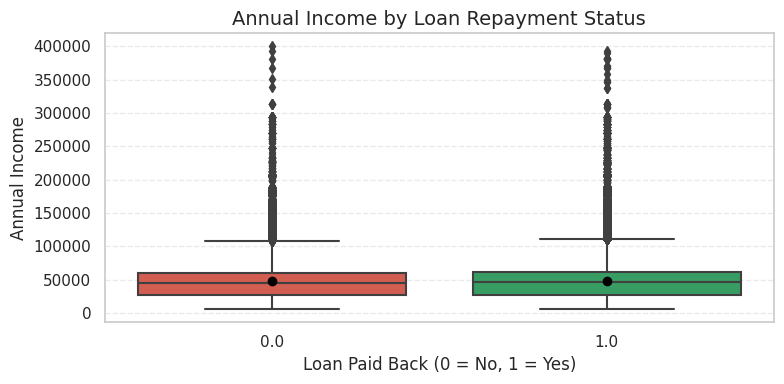

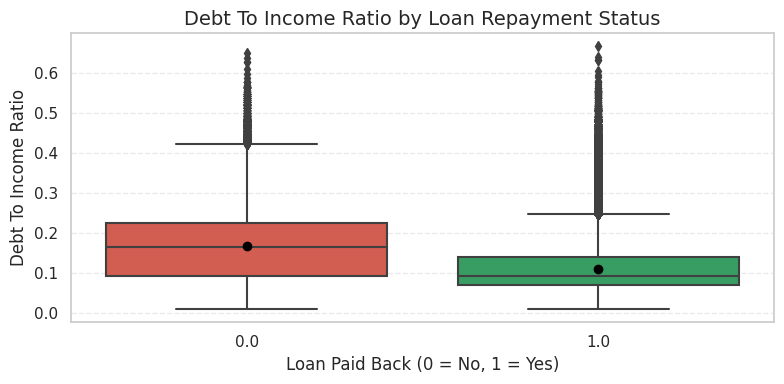

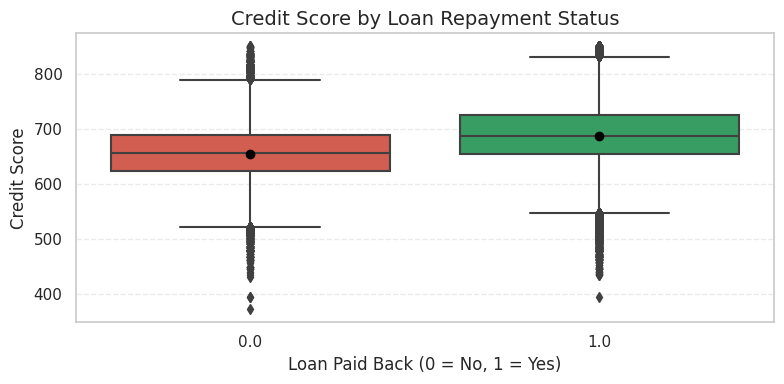

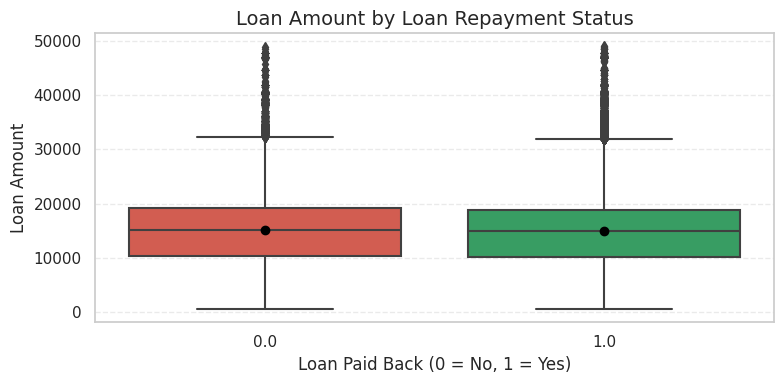

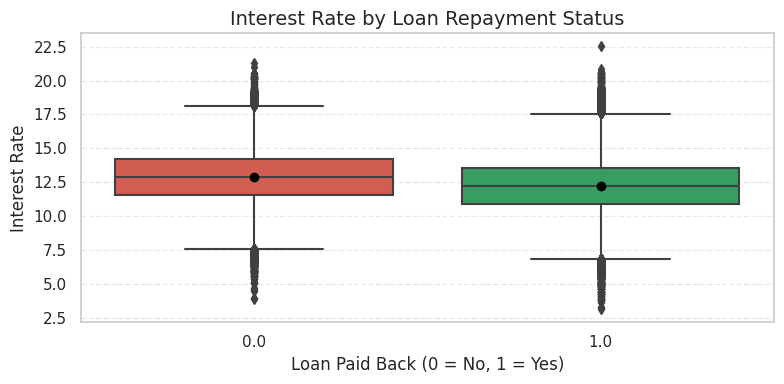

In [15]:
# 🎨 Numerical Feature Distributions by Loan Repayment Status

import matplotlib.pyplot as plt
import seaborn as sns

# Select your key numerical columns
num_cols = [
    'annual_income',
    'debt_to_income_ratio',
    'credit_score',
    'loan_amount',
    'interest_rate'
]

target_col = 'loan_paid_back'  # Binary target variable (0 = Not Paid, 1 = Paid)
custom_palette = ['#E74C3C', '#27AE60']  # Red = Not Paid, Green = Paid

for col in num_cols:
    plt.figure(figsize=(8, 4))
    
    # Left: Boxplot (distribution + outliers)
    sns.boxplot(
        data=df,
        x=target_col,
        y=col,
        palette=custom_palette,
        showmeans=True,
        meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
    )
    
    plt.title(f'{col.replace("_", " ").title()} by Loan Repayment Status', fontsize=14)
    plt.xlabel('Loan Paid Back (0 = No, 1 = Yes)', fontsize=12)
    plt.ylabel(col.replace("_", " ").title(), fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [16]:
for col in ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']:
    ctab = pd.crosstab(df[col], df['loan_paid_back'], normalize='index') * 100
    print(f"\n📊 {col} vs Loan Paid Back (%):\n")
    print(ctab.round(2))


📊 gender vs Loan Paid Back (%):

loan_paid_back    0.0    1.0
gender                      
Female          19.83  80.17
Male            20.42  79.58
Other           20.49  79.51

📊 marital_status vs Loan Paid Back (%):

loan_paid_back    0.0    1.0
marital_status              
Divorced        20.28  79.72
Married         20.08  79.92
Single          20.11  79.89
Widowed         21.05  78.95

📊 education_level vs Loan Paid Back (%):

loan_paid_back     0.0    1.0
education_level              
Bachelor's       21.10  78.90
High School      19.04  80.96
Master's         19.78  80.22
Other            19.72  80.28
PhD              17.00  83.00

📊 employment_status vs Loan Paid Back (%):

loan_paid_back       0.0    1.0
employment_status              
Employed           10.61  89.39
Retired             0.29  99.71
Self-employed      10.22  89.78
Student            72.77  27.23
Unemployed         91.90   8.10

📊 loan_purpose vs Loan Paid Back (%):

loan_paid_back        0.0    1.0
loan_purpo

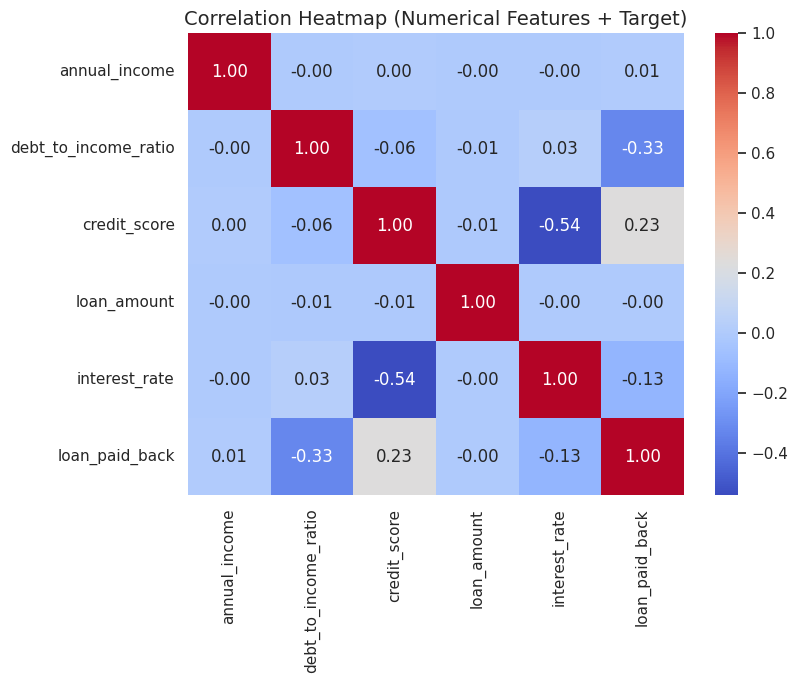

In [17]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[['annual_income', 'debt_to_income_ratio', 'credit_score', 
                'loan_amount', 'interest_rate', 'loan_paid_back']].corr(),
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap (Numerical Features + Target)', fontsize=14)
plt.show()


📊 gender vs Loan Paid Back (%):

loan_paid_back    0.0    1.0
gender                      
Female          19.83  80.17
Male            20.42  79.58
Other           20.49  79.51


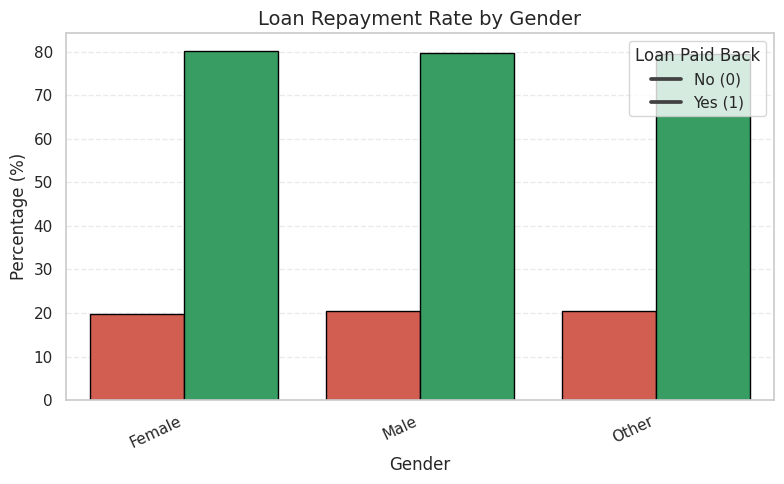


📊 marital_status vs Loan Paid Back (%):

loan_paid_back    0.0    1.0
marital_status              
Divorced        20.28  79.72
Married         20.08  79.92
Single          20.11  79.89
Widowed         21.05  78.95


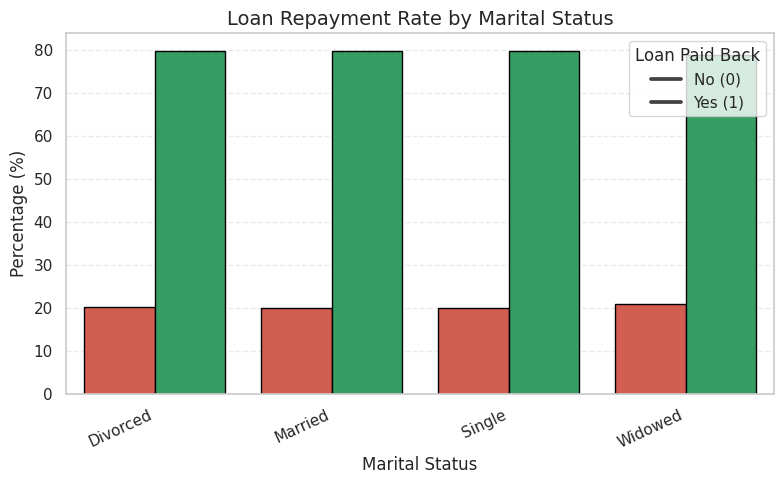


📊 education_level vs Loan Paid Back (%):

loan_paid_back     0.0    1.0
education_level              
Bachelor's       21.10  78.90
High School      19.04  80.96
Master's         19.78  80.22
Other            19.72  80.28
PhD              17.00  83.00


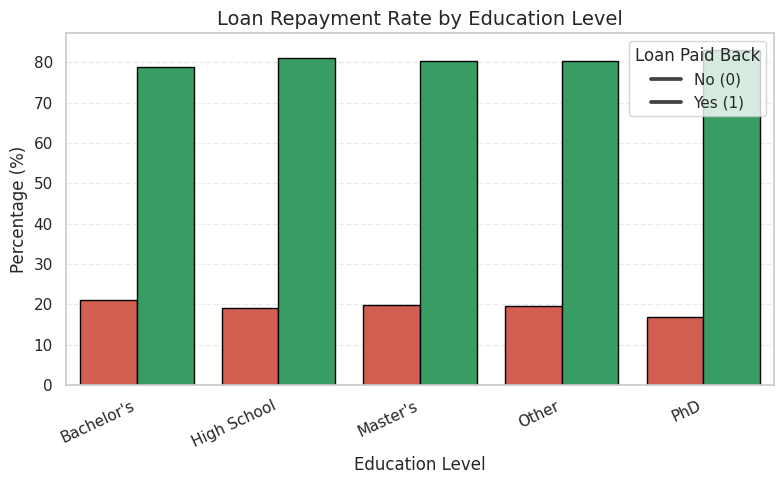


📊 employment_status vs Loan Paid Back (%):

loan_paid_back       0.0    1.0
employment_status              
Employed           10.61  89.39
Retired             0.29  99.71
Self-employed      10.22  89.78
Student            72.77  27.23
Unemployed         91.90   8.10


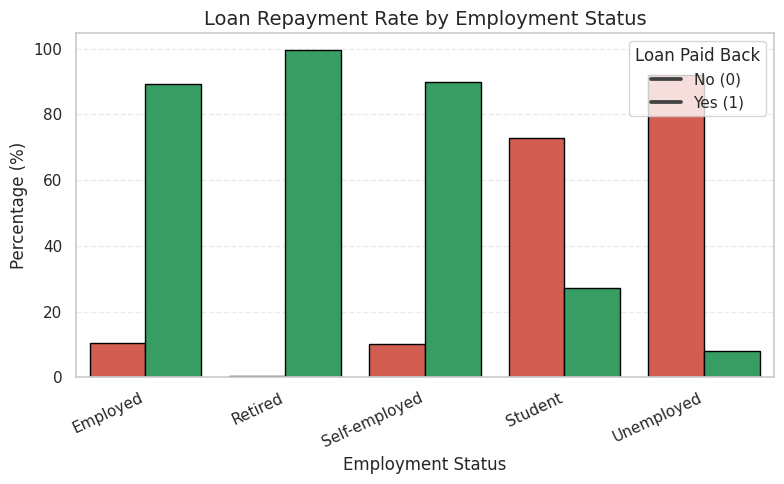


📊 loan_purpose vs Loan Paid Back (%):

loan_paid_back        0.0    1.0
loan_purpose                    
Business            18.71  81.29
Car                 19.95  80.05
Debt consolidation  20.30  79.70
Education           22.29  77.71
Home                17.67  82.33
Medical             22.17  77.83
Other               19.76  80.24
Vacation            20.42  79.58


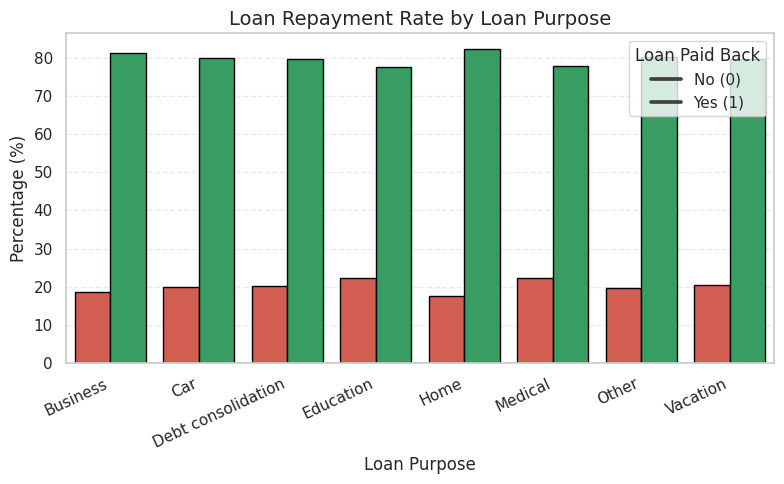

In [18]:
# Categorical columns to analyze
cat_cols = ['gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose']
target_col = 'loan_paid_back'

for col in cat_cols:
    # Calculate % of repayment within each category
    ctab = pd.crosstab(df[col], df[target_col], normalize='index') * 100
    
    print(f"\n📊 {col} vs Loan Paid Back (%):\n")
    print(ctab.round(2))
    
    # Reset for plotting
    ctab_plot = ctab.reset_index()
    ctab_plot = ctab_plot.melt(id_vars=col, var_name='Loan Paid Back', value_name='Percentage')

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(
        data=ctab_plot,
        x=col,
        y='Percentage',
        hue='Loan Paid Back',
        palette=['#E74C3C', '#27AE60'],  # red = not paid, green = paid
        edgecolor='black'
    )
    
    plt.title(f'Loan Repayment Rate by {col.replace("_", " ").title()}', fontsize=14)
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(rotation=25, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.legend(title='Loan Paid Back', labels=['No (0)', 'Yes (1)'])
    plt.tight_layout()
    plt.show()

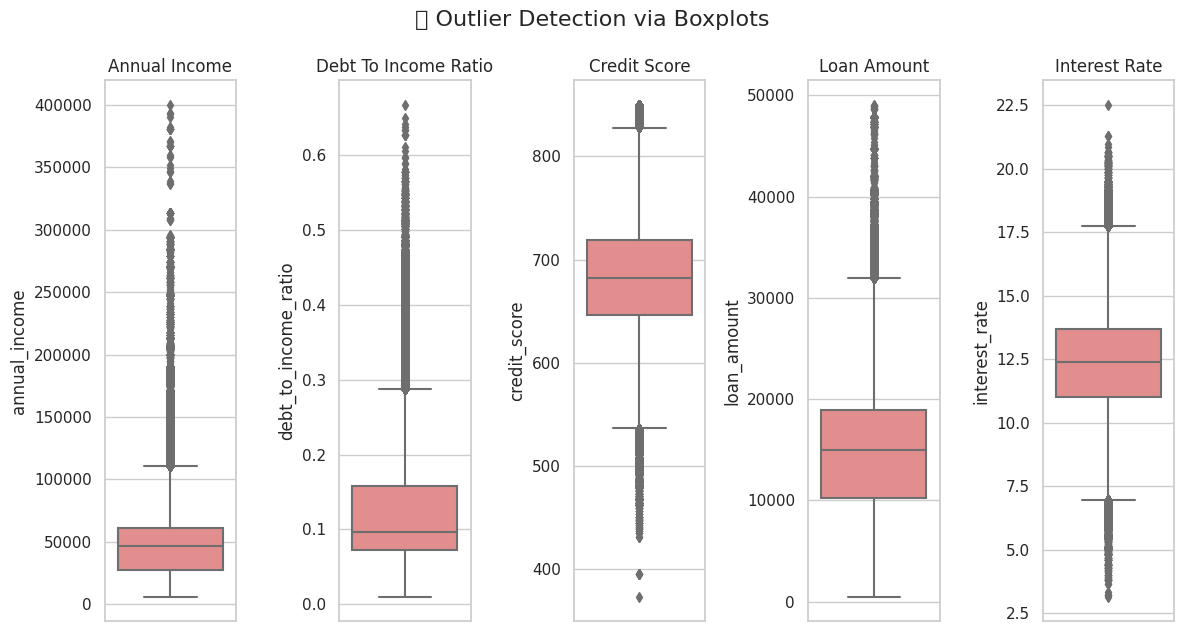

In [19]:
# Outlier Detection

num_cols = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']

plt.figure(figsize=(12, 6))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    sns.boxplot(y=df[col], color='lightcoral')
    plt.title(col.replace('_', ' ').title())
    plt.tight_layout()
plt.suptitle('📦 Outlier Detection via Boxplots', fontsize=16, y=1.05)
plt.show()

# Data Preprocessing

In [20]:
# =============================================================================
# DATA PREPARATION
# =============================================================================

# Split into train/test sets
train_df = df[df["dataset"] == "train"].copy()
test_df = df[df["dataset"] == "test"].copy()

print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print(f"Missing target values: {train_df['loan_paid_back'].isna().sum()}")

# Separate features and target
X_train = train_df.drop(["id", "loan_paid_back", "dataset"], axis=1)
y_train = train_df["loan_paid_back"]

X_test = test_df.drop(["id", "loan_paid_back", "dataset"], axis=1)

# =============================================================================
# FEATURE ENGINEERING (OPTIONAL)
# =============================================================================


# =============================================================================
# TARGET ENCODING + PREPROCESSING
# =============================================================================

# Define feature types
num_cols = [
    "annual_income",
    "debt_to_income_ratio",
    "credit_score",
    "loan_amount",
    "interest_rate"
]

cat_cols = [
    "gender",
    "marital_status",
    "education_level",
    "employment_status",
    "loan_purpose",
    "grade_subgrade"
]

# You can add binary flags (if any exist)
bool_cols = []  

# Columns to encode using Target Encoding (categorical + bools)
cols_to_encode = cat_cols + bool_cols

# ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("target_enc", TargetEncoder(cols=cols_to_encode, smoothing=25.0), cols_to_encode),
        ("scaler", StandardScaler(), num_cols)
    ],
    remainder="drop"
)

Training samples: 613994
Test samples: 254569
Missing target values: 0


In [21]:
# # =============================================================================
# # IMPORTS (add these on top of your notebook/script)
# # =============================================================================
# import cudf
# from cuml.preprocessing import TargetEncoder as cuTargetEncoder
# from cuml.preprocessing import StandardScaler as cuStandardScaler

# # =============================================================================
# # DATA PREPARATION
# # =============================================================================

# # Split into train/test sets
# train_df = df[df["dataset"] == "train"].copy()
# test_df  = df[df["dataset"] == "test"].copy()

# print(f"Training samples: {len(train_df)}")
# print(f"Test samples: {len(test_df)}")
# print(f"Missing target values: {train_df['loan_paid_back'].isna().sum()}")

# # Separate features and target
# X_train = train_df.drop(["id", "loan_paid_back", "dataset"], axis=1)
# y_train = train_df["loan_paid_back"]

# X_test  = test_df.drop(["id", "loan_paid_back", "dataset"], axis=1)

# # =============================================================================
# # FEATURE ENGINEERING (OPTIONAL)
# # =============================================================================
# # ... your feature engineering on X_train / X_test here (if any) ...


# # =============================================================================
# # TARGET ENCODING + PREPROCESSING (cuML on GPU)
# # =============================================================================

# # Define feature types
# num_cols = [
#     "annual_income",
#     "debt_to_income_ratio",
#     "credit_score",
#     "loan_amount",
#     "interest_rate"
# ]

# cat_cols = [
#     "gender",
#     "marital_status",
#     "education_level",
#     "employment_status",
#     "loan_purpose",
#     "grade_subgrade"
# ]

# bool_cols = []   # add any binary flags here if you have them
# cols_to_encode = cat_cols + bool_cols

# # --- send data to GPU (cuDF) ---
# X_train_gpu = cudf.from_pandas(X_train)
# X_test_gpu  = cudf.from_pandas(X_test)
# y_train_gpu = cudf.Series(y_train.values)

# # --- cuML Target Encoding per categorical column (fit on train, transform test) ---
# te_encoders = {}  # keep if you want to reuse encoders later

# for col in cols_to_encode:
#     te = cuTargetEncoder(
#         n_folds=5,
#         smooth=25.0,   # similar idea to your smoothing=25.0
#         seed=42
#     )
#     # fit+encode train
#     X_train_gpu[col] = te.fit_transform(X_train_gpu[col], y_train_gpu)
#     # encode test
#     X_test_gpu[col]  = te.transform(X_test_gpu[col])
#     te_encoders[col] = te

# # --- cuML StandardScaler on numeric columns (fit on train, transform test) ---
# scaler_gpu = cuStandardScaler()
# X_train_gpu[num_cols] = scaler_gpu.fit_transform(X_train_gpu[num_cols])
# X_test_gpu[num_cols]  = scaler_gpu.transform(X_test_gpu[num_cols])

# # =============================================================================
# # FINAL MATRICES FOR MODELS
# # =============================================================================

# # If you use GPU models (cuML, XGBoost GPU, etc.), keep them as cuDF:
# X_train_final_gpu = X_train_gpu
# X_test_final_gpu  = X_test_gpu
# y_train_final_gpu = y_train_gpu

# # # If you want to stay with sklearn/CPU models, convert back to pandas:
# # X_train_final = X_train_gpu.to_pandas()
# # X_test_final  = X_test_gpu.to_pandas()
# # y_train_final = y_train  # already pandas Series


In [22]:
X_train

,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,age,monthly_income,loan_term,installment,num_of_open_accounts,total_credit_limit,current_balance,delinquency_history,public_records,num_of_delinquencies
0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
868558,39640.08,0.275,691,16322.23,15.05,Female,Married,Bachelor's,Employed,Debt consolidation,C5,39.0,3303.34,36.0,566.22,2.0,23748.10,5801.45,1.0,0.0,4.0
868559,32062.90,0.367,758,16697.34,11.89,Female,Married,Bachelor's,Employed,Debt consolidation,B5,66.0,2671.91,36.0,553.71,8.0,49929.65,40901.31,3.0,0.0,3.0
868560,18642.02,0.106,751,23924.78,10.06,Female,Single,Master's,Student,Debt consolidation,B4,65.0,1553.50,36.0,772.66,3.0,13137.57,5075.67,1.0,0.0,2.0
868561,22181.39,0.275,646,16920.13,16.06,Male,Married,Master's,Retired,Other,D2,35.0,1848.45,36.0,595.36,5.0,19580.82,3876.16,4.0,0.0,5.0


# Machine Learning


CROSS-VALIDATION RESULTS (5-Fold)

CatBoost:
----------------------------------------
Accuracy:  0.8697
Precision: 0.9435
Recall:    0.8902
F1-score:  0.9161
ROC-AUC:   0.9216

XGBoost:
----------------------------------------


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [22:37:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [22:37:51] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

Accuracy:  0.9042
Precision: 0.9082
Recall:    0.9790
F1-score:  0.9423
ROC-AUC:   0.9210

MODEL PERFORMANCE SUMMARY (5-Fold CV)
          Accuracy  Precision  Recall      F1  ROC_AUC
CatBoost    0.8697     0.9435  0.8902  0.9161   0.9216
XGBoost     0.9042     0.9082  0.9790  0.9423   0.9210


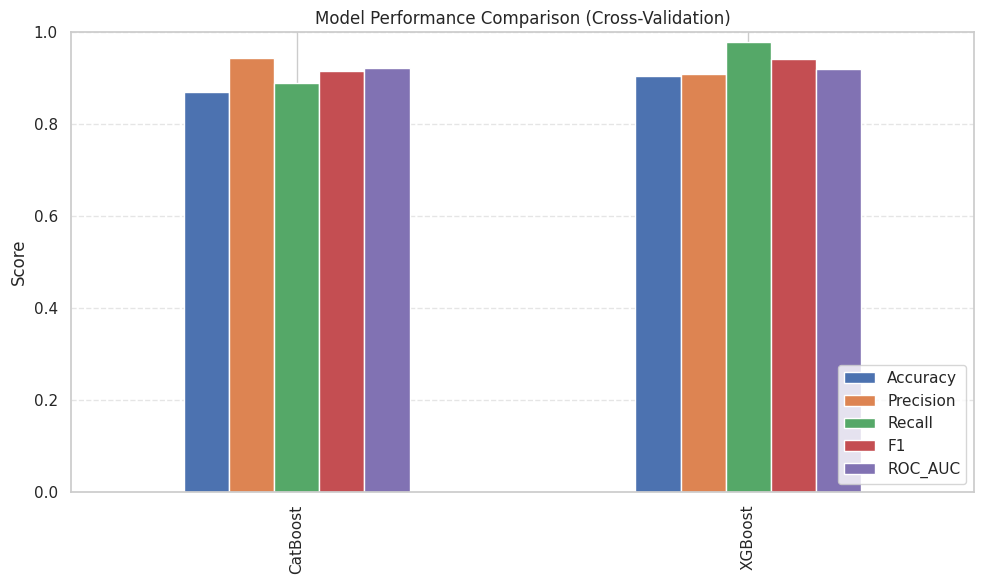

In [23]:
# =============================================================================
# DEFINE MODELS
# =============================================================================

models = {
    # "LightGBM": LGBMClassifier(
    #     metric='auc',
    #     n_estimators=1000,
    #     learning_rate=0.03,
    #     max_depth=6,
    #     num_leaves=50,
    #     colsample_bytree=0.8,
    #     subsample=0.8,
    #     subsample_freq=1,
    #     min_child_samples=20,
    #     reg_alpha=0.05,
    #     reg_lambda=0.1,
    #     random_state=42,
    #     n_jobs=-1,
    #     device='gpu',
    #     verbose=-1
    # ),
    "CatBoost": CatBoostClassifier(
        iterations=3000,
        learning_rate=0.03,
        depth=8,
        loss_function='Logloss',
        eval_metric='AUC',
        random_seed=42,
        verbose=0,
        auto_class_weights='Balanced',
        l2_leaf_reg=5
    ),
    "XGBoost": XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        learning_rate=0.01,
        max_depth=6,
        min_child_weight=3,
        colsample_bytree=0.3,
        subsample=0.6,
        reg_alpha=0.5,
        reg_lambda=2.0,
        n_estimators=10000,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        device="cuda"
    )
}

# # Ensemble model (soft voting)
# models["Ensemble_All"] = VotingClassifier(
#     estimators=[
#         ("LightGBM", models["LightGBM"]),
#         ("CatBoost", models["CatBoost"]),
#         ("XGBoost", models["XGBoost"])
#     ],
#     voting="soft",
#     weights=[1, 1, 1]
# )



# =============================================================================
# CROSS-VALIDATION SETUP
# =============================================================================

print("\n" + "=" * 80)
print("CROSS-VALIDATION RESULTS (5-Fold)")
print("=" * 80)

kfold = StratifiedKFold(n_splits=7, shuffle=True, random_state=42)
cv_results = {}

# Classification metrics
scoring = {
    "Accuracy": "accuracy",
    "Precision": "precision",
    "Recall": "recall",
    "F1": "f1",
    "ROC_AUC": "roc_auc"
}


# =============================================================================
# TRAINING + CROSS-VALIDATION
# =============================================================================

for name, model in models.items():
    print(f"\n{name}:")
    print("-" * 40)

    # Create a unified pipeline
    pipeline = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Cross-validation
    cv_scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=kfold,
        scoring=scoring,
        n_jobs=-1
    )

    # Store mean results
    cv_results[name] = {metric: np.mean(scores) for metric, scores in cv_scores.items() if "test_" in metric}

    print(f"Accuracy:  {cv_results[name]['test_Accuracy']:.4f}")
    print(f"Precision: {cv_results[name]['test_Precision']:.4f}")
    print(f"Recall:    {cv_results[name]['test_Recall']:.4f}")
    print(f"F1-score:  {cv_results[name]['test_F1']:.4f}")
    print(f"ROC-AUC:   {cv_results[name]['test_ROC_AUC']:.4f}")


# =============================================================================
# MODEL COMPARISON SUMMARY
# =============================================================================

results_df = pd.DataFrame({
    model: {
        "Accuracy": cv_results[model]["test_Accuracy"],
        "Precision": cv_results[model]["test_Precision"],
        "Recall": cv_results[model]["test_Recall"],
        "F1": cv_results[model]["test_F1"],
        "ROC_AUC": cv_results[model]["test_ROC_AUC"]
    } for model in cv_results.keys()
}).T.round(4)

print("\n" + "=" * 80)
print("MODEL PERFORMANCE SUMMARY (5-Fold CV)")
print("=" * 80)
print(results_df)

# Optional: plot comparison
results_df.plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison (Cross-Validation)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [24]:
# =============================================================================
# FINAL MODEL TRAINING (CHOOSE BEST MODEL)
# =============================================================================

best_model_name = results_df['ROC_AUC'].idxmax()
best_model = models[best_model_name]

print("\n" + "=" * 80)
print(f"FINAL MODEL: {best_model_name}")
print("=" * 80)

# Create final pipeline
final_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", best_model)
])

print(f"\nTraining final {best_model_name} model on full training data...")
final_pipeline.fit(X_train, y_train)
print("✅ Final model training complete.")


FINAL MODEL: CatBoost

Training final CatBoost model on full training data...
✅ Final model training complete.


# Submission

In [25]:
# ============================================================================
# GENERATE PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING TEST PREDICTIONS")
print("="*80)

test_predictions = final_pipeline.predict_proba(X_test)[:, 1]


GENERATING TEST PREDICTIONS


In [26]:
# ============================================================================
# CREATE SUBMISSION FILE
# ============================================================================

submission = pd.DataFrame({
    'id': test_df['id'].values,
    'loan_paid_back': test_predictions
})

submission.to_csv('submission.csv', index=False)
print(f"\n✓ Submission file saved: submission.csv")
print(f"  Shape: {submission.shape}")
print(f"\nFirst few predictions:")
print(submission.head(10))


✓ Submission file saved: submission.csv
  Shape: (254569, 2)

First few predictions:
         id  loan_paid_back
0  593994.0        0.757662
1  593995.0        0.910116
2  593996.0        0.185137
3  593997.0        0.762109
4  593998.0        0.898029
5  593999.0        0.912243
6  594000.0        0.952437
7  594001.0        0.850025
8  594002.0        0.844267
9  594003.0        0.000665


# Please Upvote If You LIke It¶
# It will be Updated
# Thanks